# CNN for Image Denoising

## GPU implementation
We used Jax capabilities to run the code on GPU, especially the optimized version of the convolution offered by the lax module. This module offers primitive operations that are at the base of other modules, such as jax.numpy. Specifically, we used the `lax.conv_general_dilated` function, which is a general n-dimensional convolution operator, with optional dilation.
First of all, we need to reshape the input image, by adding two extra dimenions at the beginning, which are the batch size and the number of channels. The input image is a grayscale image, so the number of channels is 1. The output image is also a grayscale image, so again the number of channels is 1. The batch size is 1, so both the input and output images have shape `(1, 1, 28, 28)`.
The same operation is applied to the kernel, thus changing its shape to `(1, 1, 3, 3)`. We use a stride of 1 to perform the convolution, since we should not skip any pixel during the denoising process. The padding scheme is 'SAME', since the size of the output image is the same as the input image. Of course, we do not want any dilation. Lastly, we reshape the output tensor to have the original shape of the input.
The convolution operation implemented in the lax module proved way more efficient than the hand written one, since it is automatically integrated with the cuDNN library for NVIDIA GPUs.  

## Performance Tests
First of all, let us note that the input size is always a single 28x28 image, which does not provide a huge degree of parallelization per se. Nonetheless, the GPU capabilites of jax proved very efficient with respect to the type of operation that we are applying to the image, i.e. a convolution. The CPU version is very slow, hence why we did not perform the simulation multiple times. Since the execution times are very high, the standard deviation is expected to be very low. For the simulations of the GPU versions, we performed 30 runs for each number of iterations, and we computed the mean and the standard deviation of the execution times. The results are shown in the table below. 
Note that we did not measure the time to fetch the image from the MNIST dataset, the time to apply salt & pepper noise to it, nor the time to produce and write the plot to a file. These operations are not of our interest and pollute the performance comparisons of the CNN training and the image denoising afterwards. 

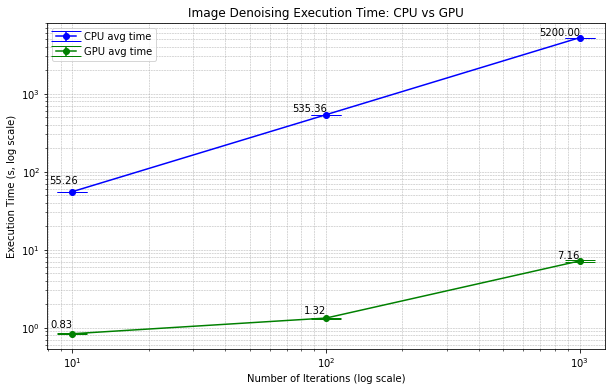

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# load the simulation data
cpu_times_10 = np.loadtxt("results/cpu_time_10.txt")
gpu_times_10 = np.loadtxt("results/gpu_time_10.txt")
# Calculate statistics
cpu_avg_10 = np.mean(cpu_times_10)
cpu_std_10 = np.std(cpu_times_10)
gpu_avg_10 = np.mean(gpu_times_10)
gpu_std_10 = np.std(gpu_times_10)
iterations = np.arange(1, len(cpu_times_10) + 1)

# same for 100 iterations
cpu_times_100 = np.loadtxt("results/cpu_time_100.txt")
gpu_times_100 = np.loadtxt("results/gpu_time_100.txt")
cpu_avg_100 = np.mean(cpu_times_100)
cpu_std_100 = np.std(cpu_times_100)
gpu_avg_100 = np.mean(gpu_times_100)
gpu_std_100 = np.std(gpu_times_100)

# same for 1000 iterations
gpu_times_1000 = np.loadtxt("results/gpu_time_1000.txt")
cpu_avg_1000 = 5200 
cpu_std_1000 = 0
gpu_avg_1000 = np.mean(gpu_times_1000)
gpu_std_1000 = np.std(gpu_times_1000)

# prepare data for plotting
iterations = np.array([10, 100, 1000])
cpu_avg = np.array([cpu_avg_10, cpu_avg_100, cpu_avg_1000])
cpu_std = np.array([cpu_std_10, cpu_std_100, cpu_std_1000])
gpu_avg = np.array([gpu_avg_10, gpu_avg_100, gpu_avg_1000])
gpu_std = np.array([gpu_std_10, gpu_std_100, gpu_std_1000])

plt.figure(figsize=(10, 6))
plt.errorbar(iterations, cpu_avg, yerr=cpu_std, fmt='-o', label='CPU avg time', capsize=15, color='blue')
plt.errorbar(iterations, gpu_avg, yerr=gpu_std, fmt='-o', label='GPU avg time', capsize=15, color='green')

# annotate the mean execution times
for i in range(len(iterations)):
    plt.text(iterations[i] + 0.5, cpu_avg[i] + 10, f"{cpu_avg[i]:.2f}", ha='right', va='bottom')
    plt.text(iterations[i], gpu_avg[i] + 0.1, f"{gpu_avg[i]:.2f}", ha='right', va='bottom')

# use logarithmic scales for better readability
plt.xscale('log')
plt.yscale('log')
plt.title("Image Denoising Execution Time: CPU vs GPU")
plt.xlabel("Number of Iterations (log scale)")
plt.ylabel("Execution Time (s, log scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


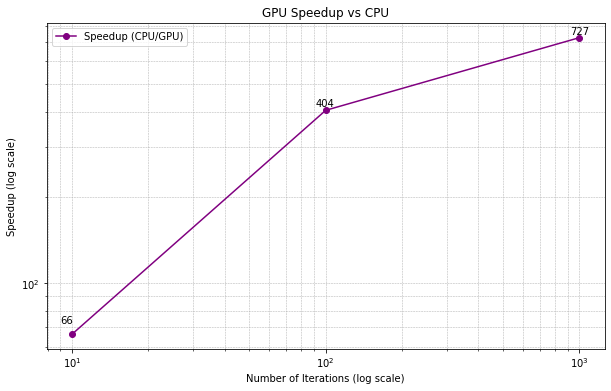

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Load the simulation data
cpu_times_10 = np.loadtxt("results/cpu_time_10.txt")
gpu_times_10 = np.loadtxt("results/gpu_time_10.txt")

# Calculate statistics for 10 iterations
cpu_avg_10 = np.mean(cpu_times_10)
cpu_std_10 = np.std(cpu_times_10)
gpu_avg_10 = np.mean(gpu_times_10)
gpu_std_10 = np.std(gpu_times_10)

# For 100 iterations
cpu_times_100 = np.loadtxt("results/cpu_time_100.txt")
gpu_times_100 = np.loadtxt("results/gpu_time_100.txt")
cpu_avg_100 = np.mean(cpu_times_100)
cpu_std_100 = np.std(cpu_times_100)
gpu_avg_100 = np.mean(gpu_times_100)
gpu_std_100 = np.std(gpu_times_100)

# For 1000 iterations
gpu_times_1000 = np.loadtxt("results/gpu_time_1000.txt")
cpu_avg_1000 = 5200
cpu_std_1000 = 0     
gpu_avg_1000 = np.mean(gpu_times_1000)
gpu_std_1000 = np.std(gpu_times_1000)
iterations = np.array([10, 100, 1000])
cpu_avg = np.array([cpu_avg_10, cpu_avg_100, cpu_avg_1000])
gpu_avg = np.array([gpu_avg_10, gpu_avg_100, gpu_avg_1000])

# compute speedup
speedup = cpu_avg / gpu_avg
plt.figure(figsize=(10, 6))
plt.plot(iterations, speedup, '-o', label='Speedup (CPU/GPU)', color='purple')
# annotate speedup values
for i in range(len(iterations)):
    plt.text(iterations[i] - 0.5, speedup[i] + 5, f"{speedup[i]:.0f}", ha='center', va='bottom')

# use logarithmic scales for better readability
plt.xscale('log')
plt.yscale('log')
plt.title("GPU Speedup vs CPU")
plt.xlabel("Number of Iterations (log scale)")
plt.ylabel("Speedup (log scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
